# Simulations

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import math as math
import random as random
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

### Local Packages ###
from utils.Prediction import *
from utils.Selector import *
from utils.Auxiliary import *
from utils.Main import *

# Input

In [2]:
### Input ###
DataFile = "BreastCancer"
rashomon_bound_adder = .5
regularization = 0.1
TestProportion = 0.2

# Train TreeFarms

In [3]:
### Load Data ###
df = LoadData(DataFile)

### Train/Test split ###
X_Train, X_Test, y_Train, y_Test = train_test_split(df.loc[:, df.columns != "Y"], df["Y"], test_size=TestProportion)
df_Train = X_Train.copy()
df_Train.insert(0, 'Y', y_Train)
df_Test = X_Test.copy()
df_Test.insert(0, 'Y', y_Test)

In [4]:
print("df_shape: " , str(df.shape[0]))
print("df_Train_shape: " , str(df_Train.shape[0]))
print("d_Test_shape: " , str(df_Test.shape[0]))


df_shape:  699
df_Train_shape:  559
d_Test_shape:  140


In [5]:
## Train TreeFarms Model ###
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

null
treefarms reported successful executionFinding Optimal Objective...
{
  "false": {
    "complexity": 0.10000000149011612,
    "loss": 0.09838998317718506,
    "name": "Y",
    "prediction": 1
  },
  "feature": 6,
  "model_objective": 0.3180679678916931,
  "name": "BareNuclei_1",
  "reference": 1,
  "relation": "==",
  "true": {
    "complexity": 0.10000000149011612,
    "loss": 0.01967799663543701,
    "name": "Y",
    "prediction": 0
  },
  "type": "integral"
}

training completed. Number of trees in the Rashomon set: 811799


# Set Up

In [6]:
### Duplicate and Unique ###
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()

### Set ###
PredictionArray = PredictionArray_Unique

### Tree Classification Accuracy ###
TreeClassificationAccuracy = PredictionArray.eq(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationAccuracy))

### Threshold Values ###
EpsilonVec = BestAccuracy - TreeClassificationAccuracy
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))
ThresholdValues = np.linspace(MinEpsilon, MaxEpsilon, 1000)

# Accuracy

In [6]:
### Threshold of Training Data ###
Epsilon_F1Score = []
Epsilon_ClassAccuracy = []
for Threshold in ThresholdValues:

    # Filter Models Based on Threshold
    ModelIndices = EpsilonVec[EpsilonVec <= Threshold].index.tolist()
    Test_Predictions = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Test.loc[:, df_Test.columns != "Y"]) for i in ModelIndices]))
    Test_Predictions.columns = df_Test.index.astype(str)

    # Compute Ensemble Prediction (Mode)
    EnsemblePrediction = pd.Series(stats.mode(Test_Predictions, axis=0, keepdims=True)[0].flatten())
    EnsemblePrediction.index = df_Test["Y"].index

    # Compute Metrics
    F1Score = f1_score(df_Test["Y"], EnsemblePrediction, average='micro')
    ClassAccuracy = np.mean(EnsemblePrediction == df_Test["Y"])

    # Append Metrics
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassAccuracy.append(ClassAccuracy)

# Plot

## Model Length

In [7]:
ThresholdValues

array([0.        , 0.00631313, 0.01262626, 0.01893939, 0.02525253,
       0.03156566, 0.03787879, 0.04419192, 0.05050505, 0.05681818,
       0.06313131, 0.06944444, 0.07575758, 0.08207071, 0.08838384,
       0.09469697, 0.1010101 , 0.10732323, 0.11363636, 0.11994949,
       0.12626263, 0.13257576, 0.13888889, 0.14520202, 0.15151515,
       0.15782828, 0.16414141, 0.17045455, 0.17676768, 0.18308081,
       0.18939394, 0.19570707, 0.2020202 , 0.20833333, 0.21464646,
       0.2209596 , 0.22727273, 0.23358586, 0.23989899, 0.24621212,
       0.25252525, 0.25883838, 0.26515152, 0.27146465, 0.27777778,
       0.28409091, 0.29040404, 0.29671717, 0.3030303 , 0.30934343,
       0.31565657, 0.3219697 , 0.32828283, 0.33459596, 0.34090909,
       0.34722222, 0.35353535, 0.35984848, 0.36616162, 0.37247475,
       0.37878788, 0.38510101, 0.39141414, 0.39772727, 0.4040404 ,
       0.41035354, 0.41666667, 0.4229798 , 0.42929293, 0.43560606,
       0.44191919, 0.44823232, 0.45454545, 0.46085859, 0.46717

# Accuracy by Rashomon Threshold

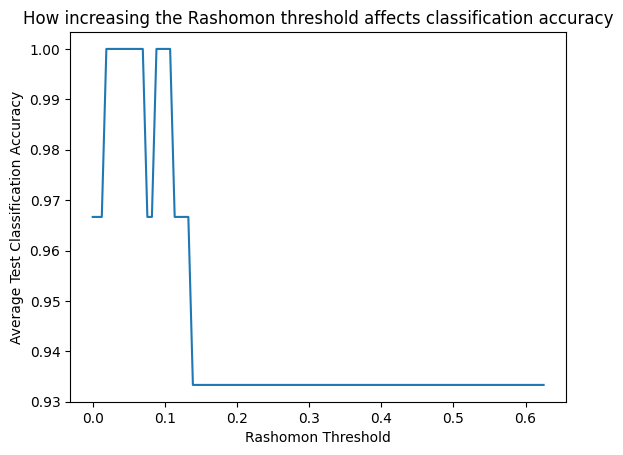

In [8]:
### Plot Accuracy ###
plt.plot(ThresholdValues, Epsilon_ClassAccuracy, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("How increasing the Rashomon threshold affects classification accuracy")
plt.show()

# F1 by Rashomon Threshold

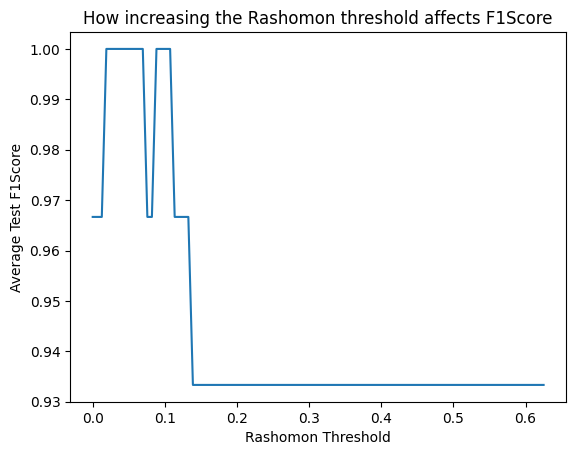

In [9]:
plt.plot(ThresholdValues, Epsilon_F1Score, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("How increasing the Rashomon threshold affects F1Score")
plt.show()